chemLTD demo analysis
=====================

In [4]:
import os
import sys
import glob
import yaml

import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io

from scipy import ndimage
from scipy import signal


## DoMB demo

In [1]:
from domb.reg_type.WF_x2_m2 import WF_2x_2m as wt

In [9]:
reg = wt(img_path='11.tif', img_name='11', soma_mask=True, soma_ext=150)

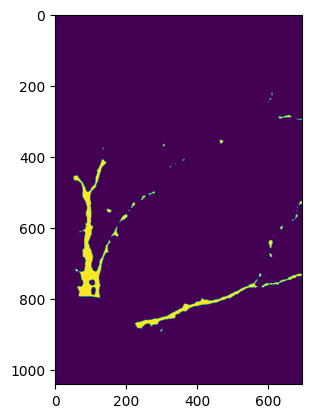

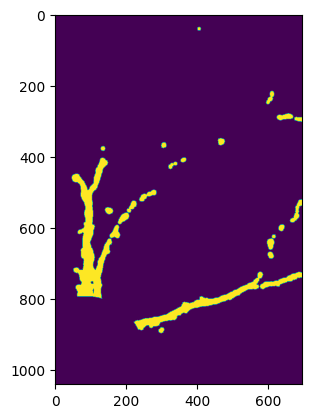

In [10]:
plt.imshow(reg.narrow_proc_mask)
plt.show()

plt.imshow(reg.proc_mask)
plt.show()

## Ctrl img

In [2]:
img_name = '11.tif'
samp_name = img_name.split('.')[0]
img_raw = io.imread(img_name)
print(img_raw.shape)

img_cfp_raw = img_raw[:,:,:,0]
img_yfp_raw = img_raw[:,:,:,3]

ch0_ctrl = np.mean(img_raw[:,:,:,0], axis=0)
ch1_ctrl = np.mean(img_raw[:,:,:,1], axis=0)
ch2_ctrl = np.mean(img_raw[:,:,:,2], axis=0)
ch3_ctrl = np.mean(img_raw[:,:,:,3], axis=0)

(50, 1040, 696, 4)


In [3]:
img_max = np.max(img_raw, axis=(0,3))
print(img_max.shape)

(1040, 696)


(90, 2, 1040, 696)


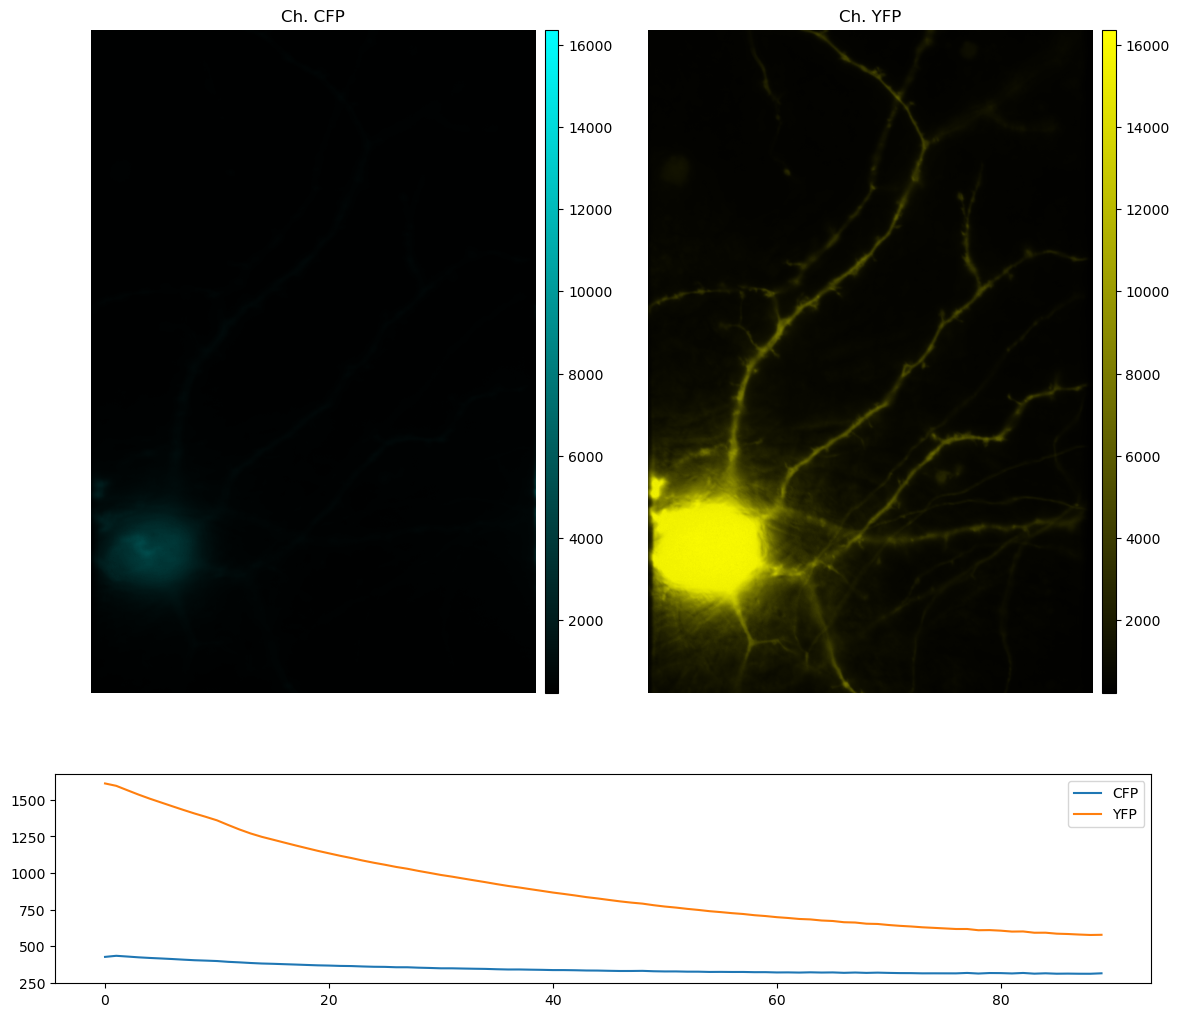

In [3]:
img_raw = io.imread('03.tif')
print(img_raw.shape)

img_cfp_raw = img_raw[:,0,:,:]
img_yfp_raw = img_raw[:,1,:,:]

img_cfp_ctrl = np.max(img_cfp_raw, axis=0)
img_yfp_ctrl = np.max(img_yfp_raw, axis=0)


plt.figure(figsize=(12,15))
ax0 = plt.subplot(221)
ax0.set_title('Ch. CFP')
img0 = ax0.imshow(img_cfp_ctrl, cmap=cmap_cyan)
img0.set_clim(vmin=np.min(img_raw), vmax=np.max(img_raw))
div0 = make_axes_locatable(ax0)
cax0 = div0.append_axes('right', size='3%', pad=0.1)
plt.colorbar(img0, cax=cax0)
ax0.axis('off')

ax1 = plt.subplot(222)
ax1.set_title('Ch. YFP')
img1 = ax1.imshow(img_yfp_ctrl, cmap=cmap_yellow)
img1.set_clim(vmin=np.min(img_raw), vmax=np.max(img_raw))
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='3%', pad=0.1)
plt.colorbar(img1, cax=cax1)
ax1.axis('off')

ax2 = plt.subplot(614)
ax2.plot([np.mean(frame) for frame in img_cfp_raw], label='CFP')
ax2.plot([np.mean(frame) for frame in img_yfp_raw], label='YFP')
ax2.legend()

plt.tight_layout()
plt.show()


img_cfp = filters.gaussian(img_cfp_raw, sigma=0.5)
img_yfp = filters.gaussian(img_yfp_raw, sigma=0.5)


## Masking and application frame detection

10


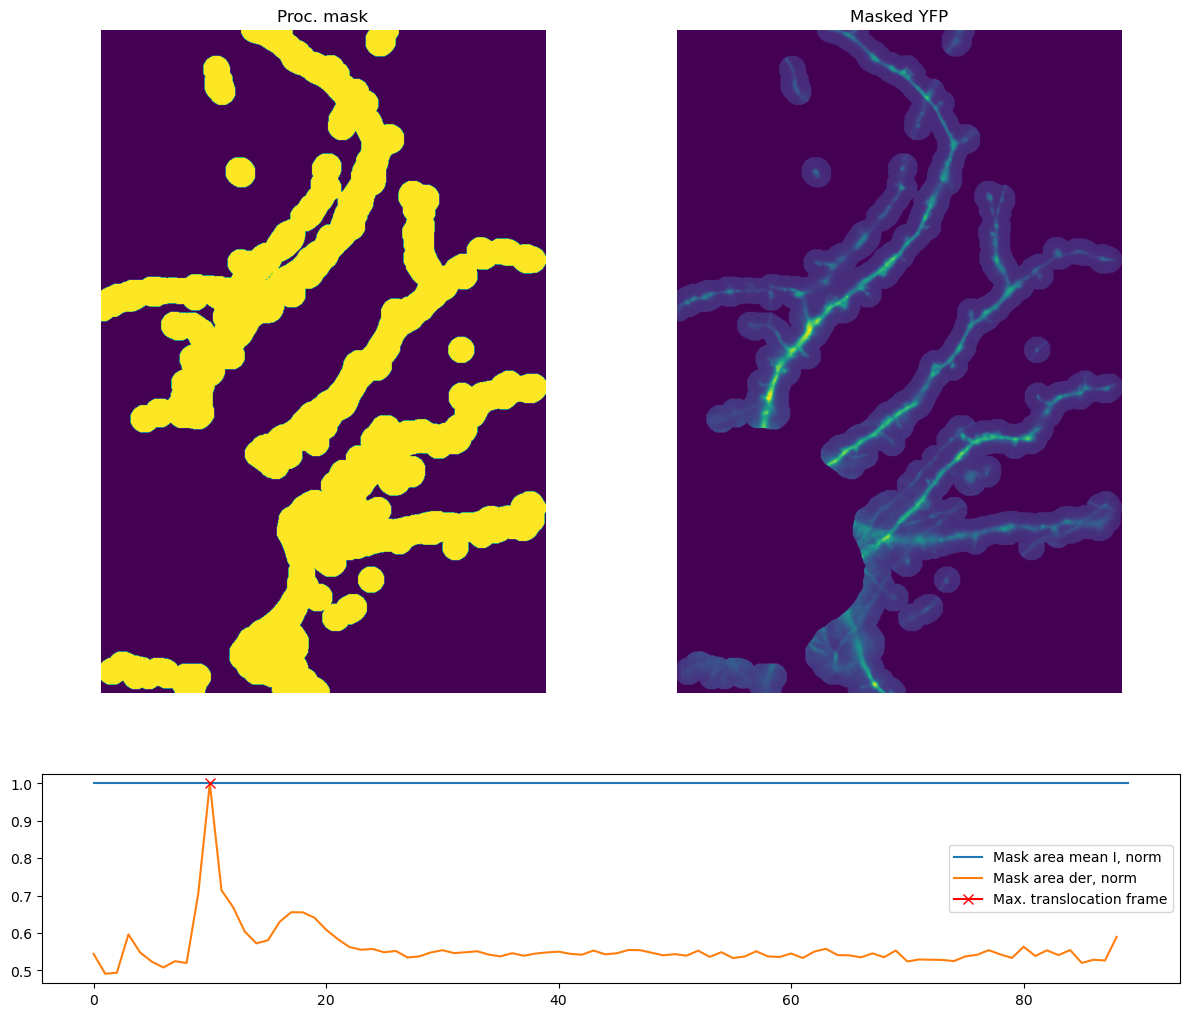

In [4]:
def pb_corr(img, base_win=4, mode='exp'):
    """ ftame series photobleaxhing crrection with exponential fit

    """
    if mode == 'exp':
        x = np.arange(0, img.shape[0], 1, dtype='float')
        y = np.asarray([np.mean(i) for i in img])

        p = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
        a = np.exp(p[1])
        b = p[0]

        fit = a * np.exp(b * x)
        fit_arr = np.asarray([z+f for z, f in zip(np.zeros_like(img), fit)])
        img_corr = (img*fit_arr) + np.mean(img[:base_win], axis=0)

        print(a, b)

        plt.plot([np.mean(i) for i in img_corr], label='corr')
        plt.plot([np.mean(i) for i in img], linestyle='--', label='raw')
        plt.plot(fit, linestyle=':', label='fit')
        plt.legend()
        plt.show()
        
    return img_corr

def cell_masking(input_img, soma_th=0.5, soma_mask=True, soma_ext=100, proc_ext=20):
    # soma masking
    if soma_mask:
        soma_region = np.copy(input_img)
        soma_region = soma_region > soma_region.max() * soma_th
        soma_region = morphology.opening(soma_region, footprint=morphology.disk(5))
        # soma_region = morphology.dilation(soma_region, footprint=morphology.disk(10))
        soma_dist = ndimage.distance_transform_edt(~soma_region, return_indices=False)
        soma_mask = soma_dist < soma_ext
        input_img[soma_mask] = 0


    # processes masking
    th = filters.threshold_otsu(input_img)
    proc_mask = input_img > th
    proc_mask = morphology.opening(proc_mask, footprint=morphology.disk(1))
    proc_dist = ndimage.distance_transform_edt(~proc_mask, return_indices=False)
    proc_mask_fin = proc_dist < proc_ext
    # proc_mask_fin =proc_mask

    return proc_mask_fin

img_yfp_max = np.max(img_yfp, axis=0)

mask = cell_masking(img_yfp_max, soma_mask=True)
mask_arr = np.asarray([z+mask for z in np.zeros_like(img_yfp)], dtype='bool')

# maskings
img_yfp_masked = np.copy(img_yfp)
img_yfp_masked[~mask_arr] = 0

# pb corr with constant val
img_yfp_masked = np.asarray([img * (np.sum(np.mean(img_yfp_masked[:2], axis=0))/np.sum(img)) for img in img_yfp_masked])


mask_prof = np.asarray([np.mean(img) for img in img_yfp_masked])
mask_prof_norm = mask_prof / mask_prof.max()
der_prof = np.asarray([np.sum(np.abs(img)) for img in (img_yfp_masked[:-1] - img_yfp_masked[1:])])
der_prof_norm = der_prof / der_prof.max()
max_frame_num = np.argmax(der_prof_norm)
print(max_frame_num)


plt.figure(figsize=(12,15))
ax0 = plt.subplot(221)
ax0.set_title('Proc. mask')
ax0.imshow(mask)
ax0.axis('off')

ax1 = plt.subplot(222)
ax1.set_title('Masked YFP')
ax1.imshow(np.max(img_yfp_masked, axis=0))
ax1.axis('off')

ax2 = plt.subplot(614)
ax2.plot(mask_prof_norm, label='Mask area mean I, norm')
ax2.plot(der_prof_norm, label='Mask area der, norm')
ax2.plot([max_frame_num], der_prof_norm[max_frame_num], marker='x', markersize=7, color='r', label='Max. translocation frame')
ax2.legend()

plt.tight_layout()
plt.show()

## Ref-green mask creation

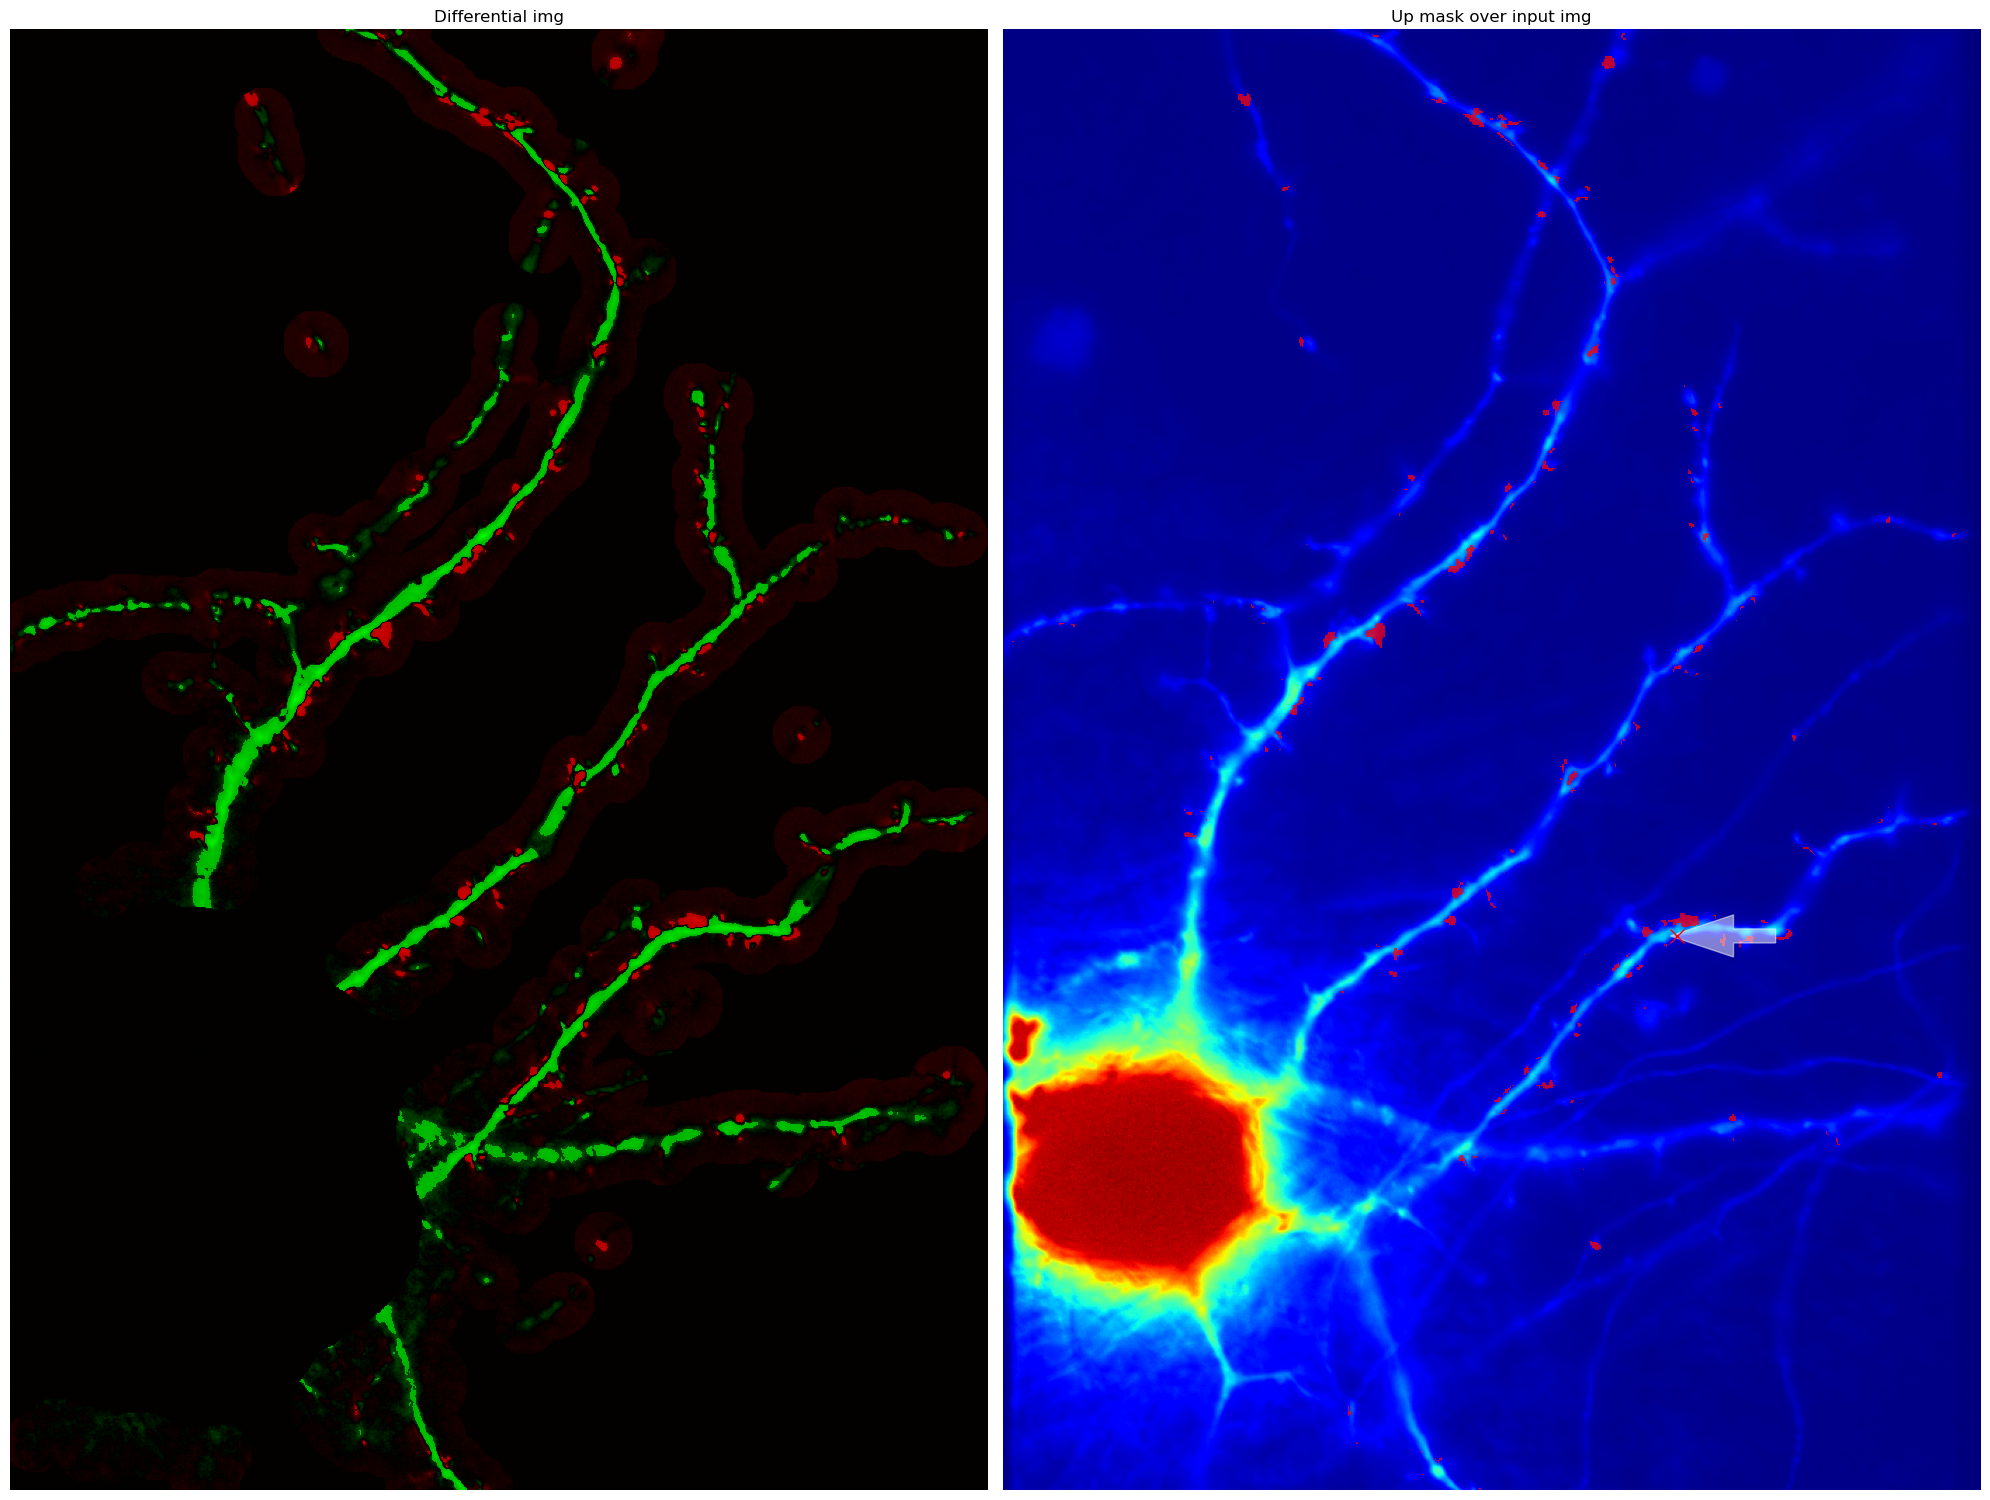

In [5]:
# differential img and up mask calc
img_base = np.mean(img_yfp_masked[:7], axis=0)
img_max = np.mean(img_yfp_masked[12:15], axis=0)

img_diff = img_max - img_base
img_diff = img_diff/np.max(np.abs(img_diff))

diff_sd = np.std(ma.masked_where(~mask, img_diff))
up_mask = img_diff > diff_sd

plt.figure(figsize=(20,20))
ax0 = plt.subplot(121)
ax0.set_title('Differential img')
ax0.imshow(img_diff, cmap=cmap_red_green, vmax=1, vmin=-1)
ax0.axis('off')

ax1 = plt.subplot(122)
ax1.set_title('Up mask over input img')
ax1.imshow(img_yfp_ctrl, cmap='jet')
ax1.imshow(ma.masked_where(~up_mask, up_mask), alpha=0.75, cmap='hsv')
ax1.plot(480, 645, marker='x', color='r', markersize=10)
ax1.arrow(550,645,-30,0,width=10, alpha=0.5, color='white')
ax1.axis('off')

plt.tight_layout()
plt.show()


## Up regions profiles

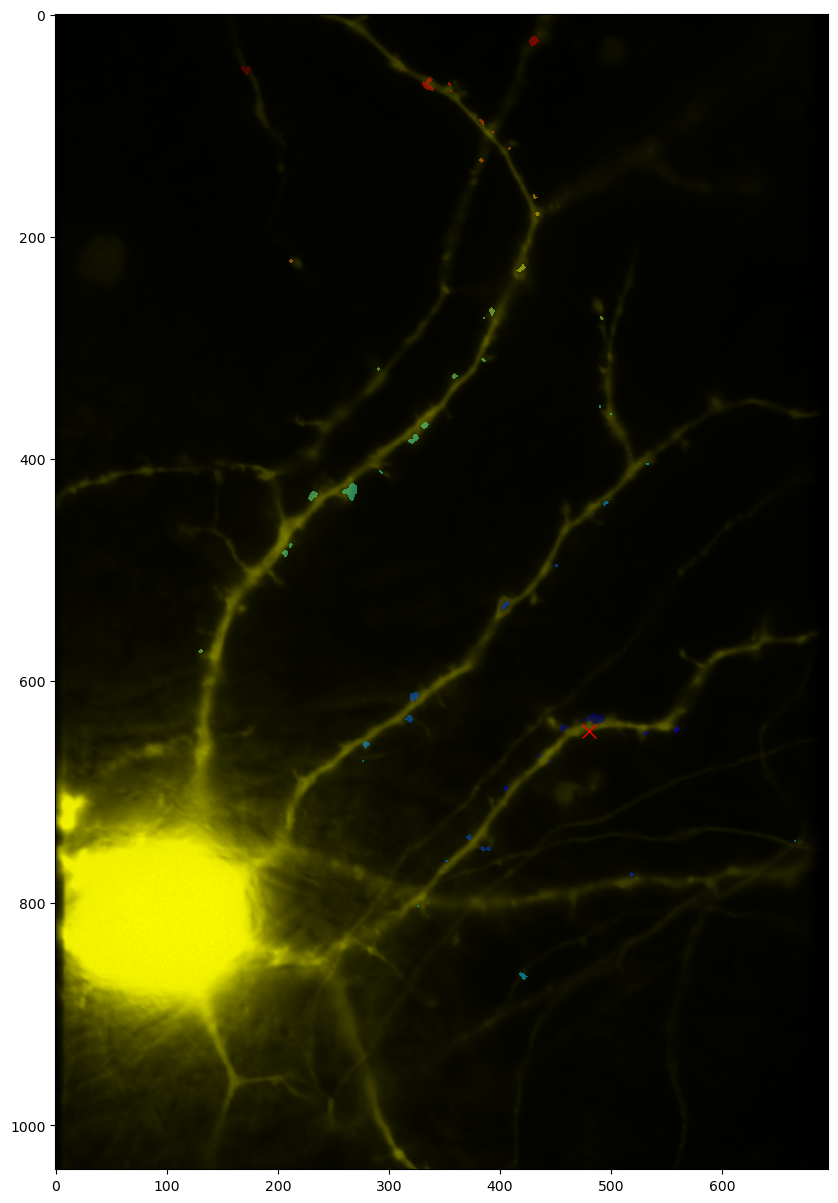

{623.6: [1, array([0.02160435, 0.02145447, 0.02147984, 0.02168661, 0.02090415,
       0.02095396, 0.02140504, 0.02187526, 0.02161408, 0.02187629,
       0.02282953, 0.02515631, 0.02557283, 0.0256358 , 0.02553127,
       0.02576171, 0.02563926, 0.02530734, 0.02539549, 0.02497925,
       0.02473098, 0.02423194, 0.0236682 , 0.02327256, 0.02248013,
       0.02220331, 0.02186393, 0.02174182, 0.02172191, 0.02140152,
       0.02164504, 0.02153475, 0.02161339, 0.02151748, 0.02149313,
       0.02153911, 0.02143146, 0.02155495, 0.02173516, 0.02149615,
       0.02151046, 0.02145882, 0.02140159, 0.02116517, 0.02118288,
       0.02118407, 0.02126204, 0.02128551, 0.02132924, 0.02127807,
       0.02128086, 0.02114345, 0.02129149, 0.02133113, 0.02123315,
       0.02124131, 0.02137038, 0.02142775, 0.02146562, 0.02121228,
       0.02117662, 0.02140122, 0.02132968, 0.02136375, 0.0213673 ,
       0.02140434, 0.02114166, 0.02114685, 0.02127574, 0.02125763,
       0.02128232, 0.02131729, 0.02130802, 0.02132

In [11]:
up_mask_filt = morphology.opening(up_mask, footprint=morphology.disk(2))
up_label = measure.label(up_mask_filt)


# pipett tip position mask
pipet_mask = np.ones_like(img_yfp_ctrl)
pipet_mask[645, 480] = 0

dist_img = ndimage.distance_transform_edt(pipet_mask)
dist_img = ma.masked_where(~up_mask_filt, dist_img)


plt.figure(figsize=(30,15))
plt.imshow(img_yfp_ctrl, cmap=cmap_yellow)
plt.imshow(dist_img, cmap='jet', alpha=.5)
plt.plot(480, 645, marker='x', color='r', markersize=10)
plt.show()


raw_prof_dict = {}
for label_num in range(1, np.max(up_label)+1):
    up_region_mask = up_label == label_num
    prof = np.asarray([np.mean(ma.masked_where(~up_region_mask, img)) for img in img_yfp_masked])
    F_0 = np.mean(prof[:5])
    df_prof = (prof-F_0)/F_0
    dist = round(np.mean(ma.masked_where(~up_region_mask, dist_img)), 1)
    raw_prof_dict.update({dist:[label_num,prof, df_prof]})

print(raw_prof_dict)

# plt.figure(figsize=(10,15))
# for i in raw_prof_dict.keys():
#     plt.plot(raw_prof_dict[i])

# plt.show()

# plt.figure(figsize=(30,15))
# plt.imshow(up_label)

In [16]:
sorted_dist = list(raw_prof_dict.keys())
sorted_dist.sort(key=float)

prof_arr = []
prof_id = []
prof_dist = []
for dist in sorted_dist:
    roi_data = raw_prof_dict[dist]
    roi_id = roi_data[0]
    roi_prof = roi_data[1]
    roi_prof_df = roi_data[2]
    if np.max(roi_prof_df) > 0.25:
        print(dist)
        prof_id.append(roi_id)
        prof_arr.append(roi_prof_df)
        prof_dist.append(dist)
prof_id = np.asarray(prof_id)
prof_arr = np.asarray(prof_arr)

prof_dist = np.asarray(prof_dist)

32.2
79.1
141.2
144.2
151.8
205.3
210.7
245.8
292.2
306.2
372.2
377.1
383.7
483.4
500.8
589.2
595.9
599.7
670.6


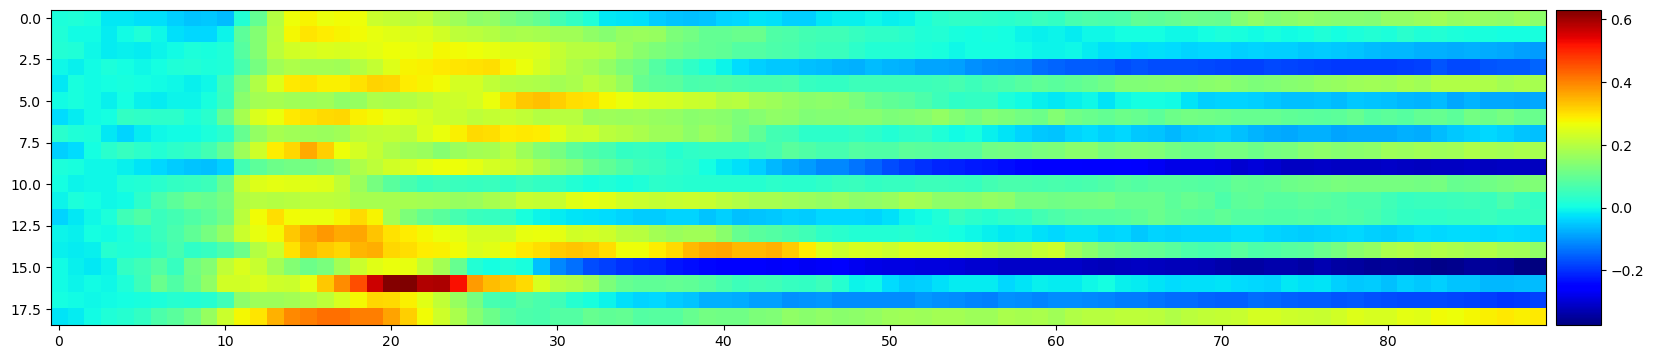

In [23]:
fig, ax = plt.subplots(figsize=(20,20))
img = ax.imshow(prof_arr, cmap='jet')  # , aspect = 2.5)
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='3%', pad=0.1)
plt.colorbar(img, cax=cax)
# plt.yticks(ticks=range(0,len(prof_dist)), labels=prof_dist)

# fig0, ax0 = plt.subplots(figsize=(20,20))
# img0 = ax0.imshow(prof_arr, cmap='jet')
# # img0.set_clim(vmin=np.min(img_raw), vmax=np.max(img_raw))
# div0 = make_axes_locatable(ax0)
# cax0 = div0.append_axes('right', size='0.5%', pad=0.1)
# # plt.yticks(ticks=range(0,len(prof_dist)), labels=prof_dist)
# fig0.colorbar(img0, cax=cax0)

# plt.tight_layout()
# plt.show()

#### Profiles extration

In [ ]:
# profile = [np.mean(ma.masked_where(-fin_mask, frame)) for frame in img_raw]

plt.figure(figsize=(20, 8))

prof_arr = []
i = 0
for label in range(1, np.max(labels)+1):
    mask = labels == label
    prof = [np.mean(ma.masked_where(~mask, frame)) for frame in img_raw]
    prof_arr.append(prof)
    plt.plot(prof, label=label)
    i += 200

plt.legend()
plt.show()

prof_arr = np.asarray(prof_arr)

print(prof_arr.shape)
